<h2>Heterodyne Phase Camera Simulator(hpc_sim)</h2>
This notebook will run you through the basic of using the hpc sim package. This package aims to provide tools for creating realitic intensity images for testing the performance of phase retrieval algorithms. So let's begin by setting up our environment.

In [2]:
import hpc 
import numpy as np
import matplotlib.pyplot as plt
import pykat as pk

# These are just personal preferences of mine and are not necessary for you.
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

<h3> Initialize a CMOS sensor </h3>
Within the package a CMOS object is defined with some useful functions for adding realism to an image that is passed into it. So most simulations of this nature will start with the definition of a CMOS_sensor object. In this object you can define the pixel pitch, sensor array resolution, quantum efficieny, exposure time, and pixel well depth. These have been set to the values of the Blackfly S by default, but can of course can be changed.

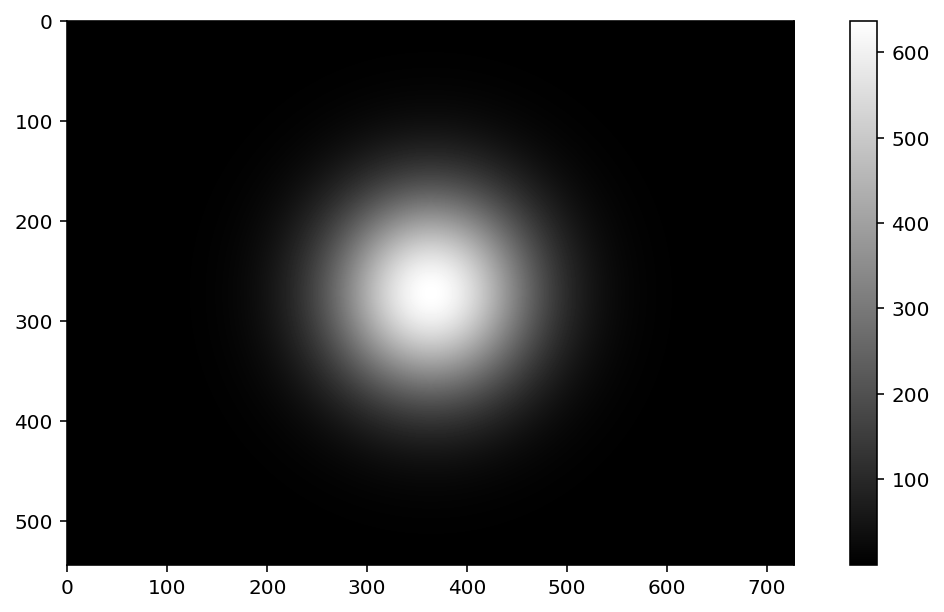

In [3]:
sensor = hpc.CMOS_sensor(pixel_pitch=6.9e-6, x_resolution=728, y_resolution=544, exposure_time=4e-6, quantum_eff=0.03, pixel_well_depth=22187) 
# sensor = hpc.CMOS_sensor() will do the same thing, however just to show you how you can set different values upon initalization

# the sensor will generate arrays with the spatial location of each pixel. This is used when trying to produce intensity images,
# as you need these to define a gaussian beam.

x_array = sensor.x_array
y_array = sensor.y_array

# Using these arrays let us generate a basic intensity image of a gaussian beam. Within the package is a gauss_amp function.
# This will produce an image of the right size representative of the amplitude profile of a gaussian beam.

amplitude_map = hpc.gauss_amp(x_array, y_array, w0=1e-3, z=0, x_offset=0, y_offset=0)
intensity_map = np.real(1e-3*amplitude_map*np.conj(amplitude_map))
hpc.plot(intensity_map, cmap='gray')

That's a pretty good looking beam! Now let's make it a little more real. Within the sensor we can convert an intensity image into a photon count, add shot noise, convert that to an electron count, add camera noise, and then digitize the image.

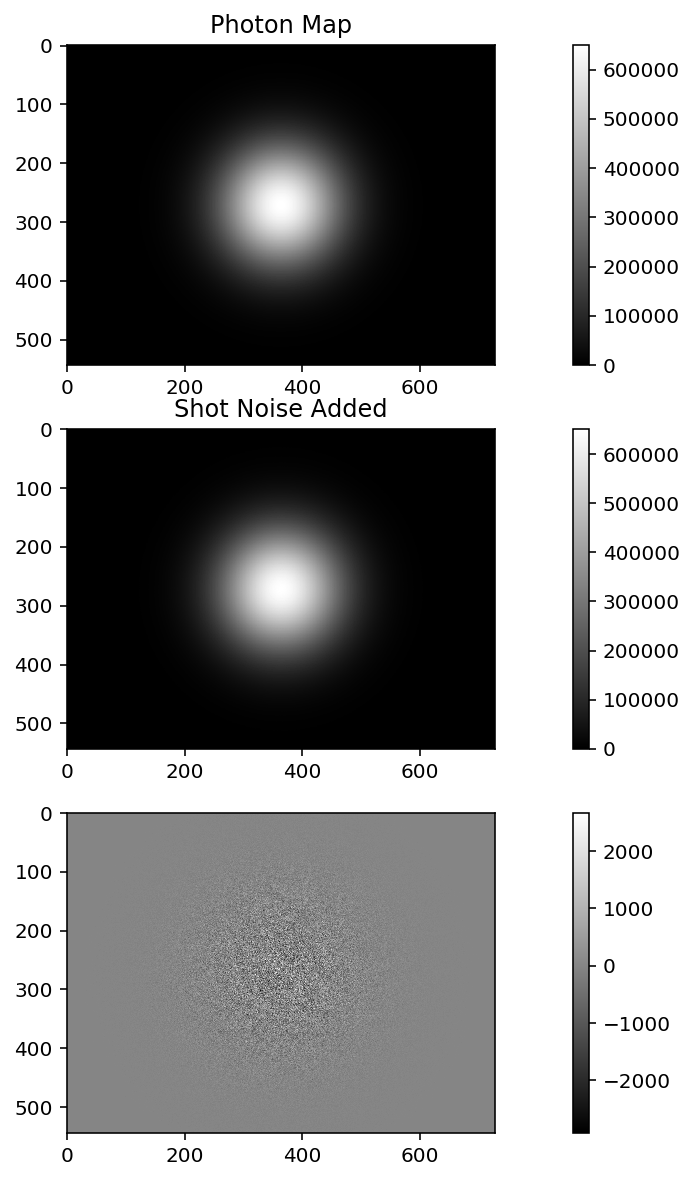

In [4]:
rcParams['figure.figsize'] = 14, 10

# First let's get our photons
photon_map = sensor.convert_to_photons(intensity_map)

# and now let's add some shot noise
noisey_photon_map = sensor.add_shot_noise(photon_map)

plt.subplot(3,1,1)
hpc.plot(photon_map)
plt.title('Photon Map')

plt.subplot(3,1,2)
hpc.plot(noisey_photon_map)
plt.title('Shot Noise Added')


#Doesn't really look like anything has happened but if we subtract the two it becomes apparent
plt.subplot(3,1,3)
hpc.plot(photon_map - noisey_photon_map)

Let's convert this to electrons, add read noise, and digitize this image.

Text(0.5, 1.0, 'Digitized image')

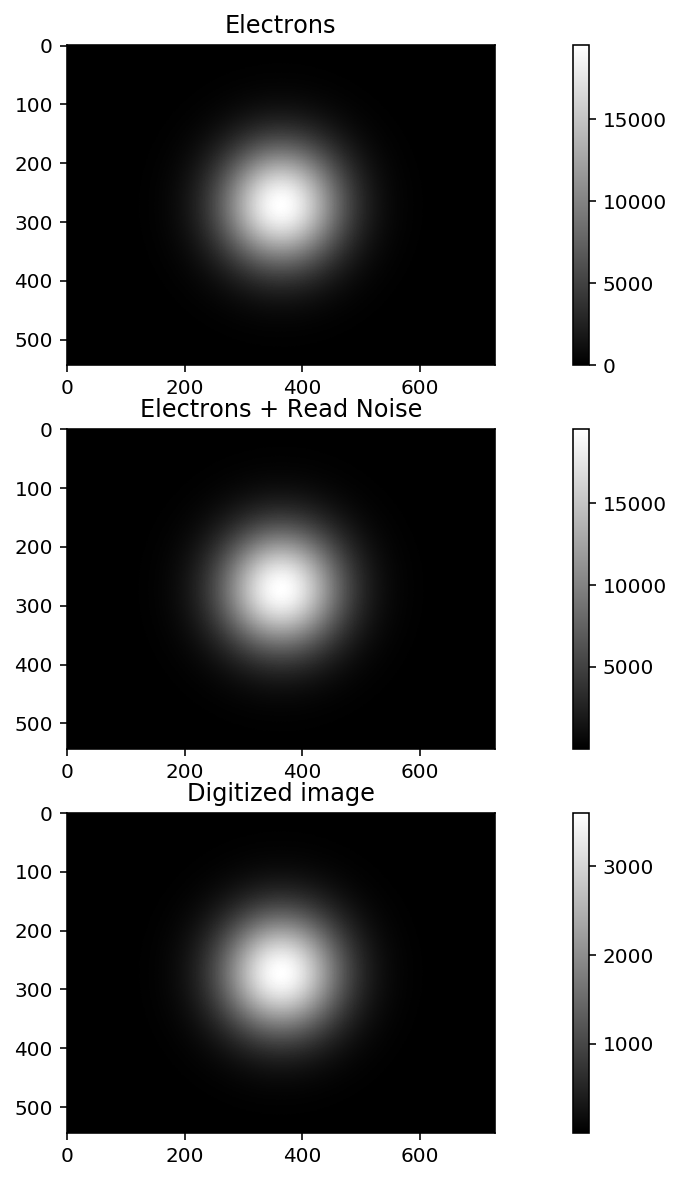

In [5]:
electron_map = sensor.convert_to_electrons(noisey_photon_map, convert_to_photons=False)
noisey_electron_map = sensor.add_read_noise(electron_map, mean=3.71)
digitized_image = sensor.digitize(noisey_electron_map, bitdepth=12)

plt.subplot(3,1,1)
hpc.plot(electron_map)
plt.title('Electrons')

plt.subplot(3,1,2)
hpc.plot(noisey_electron_map)
plt.title('Electrons + Read Noise')

#Doesn't really look like anything has happened but if we subtract the two it becomes apparent
plt.subplot(3,1,3)
hpc.plot(digitized_image)
plt.title('Digitized image')

Now that we've gone through all this, I should say that all these steps can be done in one function call. Again if you are not using this for the blackfly you will need to set your values.

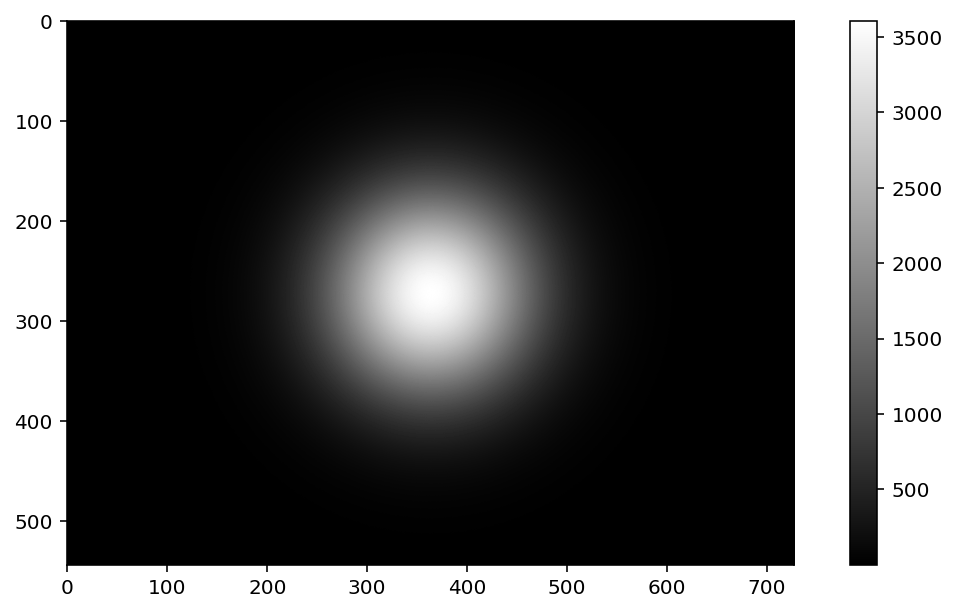

In [6]:
rcParams['figure.figsize'] = 10, 5
image = sensor.capture(intensity_map, 12)
hpc.plot(image)

<h2> Beams </h2>
Another class that is in this package is the beam class. This object will hold some beam characteristics and allow you to generate an amplitude image, two of these will allow you to form a beat note, or a general intensity image.

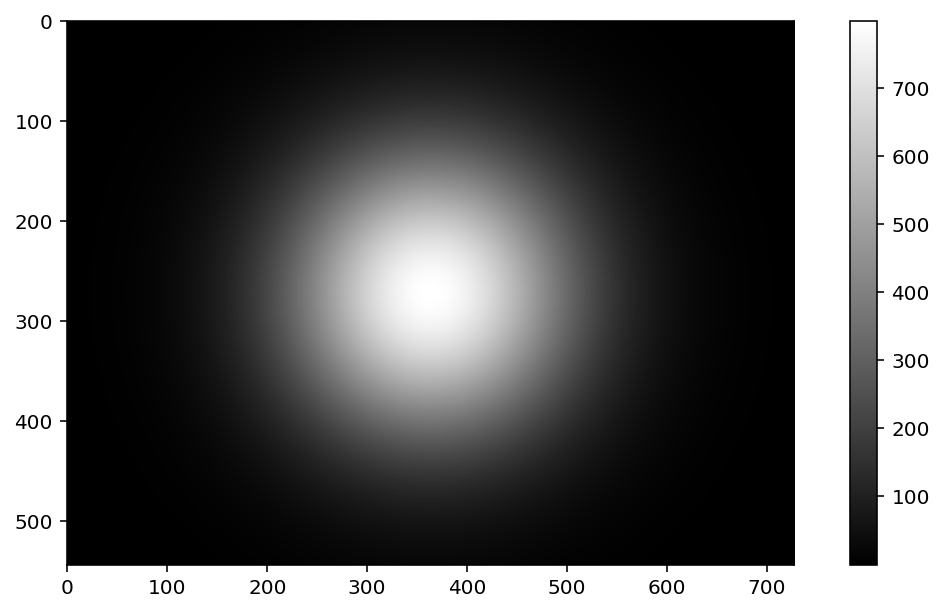

In [7]:
beam1 = hpc.beam(power=1, w0=1e-3, z=0, spatial="gauss")

# now that we have defined this beam let's generate an amplitude map, this function will need us to feed in the previous x/y array. 
beam1_amp = beam1.generate_amplitude_map(x_array, y_array)

# when plotting an amplitude you must plot either the real part or the imaginary. The plotting function does not respond well to 
# complex numbers.
hpc.plot(np.real(beam1_amp))

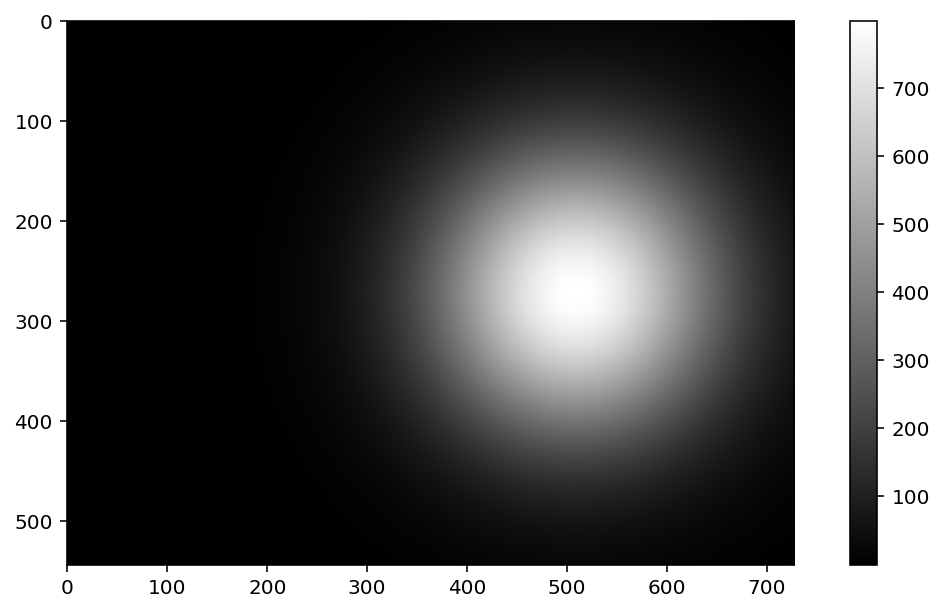

In [8]:
# you can also shift the position of the beam by adding in an x/y offset
beam1_amp_shifted = beam1.generate_amplitude_map(x_array, y_array, x_offset=1e-3)
hpc.plot(np.real(beam1_amp_shifted))

<h2>Beat Notes and Phase Images</h2>
Since this module was mainly made to look at phase images generated from a beat note incident on the sensor, let's look at this aspect of the package. In order to generate a beat note you will need two beams, so let us just use the first amplitude twice. 

In [9]:
# Let us assume that we are going to capture images at 40 Hz and that we will capture for 1 second
time = hpc.time_array(no_images=40, collection_time=1)

# Using this time array, and a beatnote frequency of 10 Hz we can generate an array of images
beat_note = hpc.generate_beatnote(beam1_amp, beam1_amp, 10, time)

# A handy function for visualizing what is happening is the animate function. This will take all the images and generate a short movie to see how the beatnote
# or any list of images evolves over time

hpc.animate_images(beat_note, cmap='gray')
#np.max(beam2_amp)

Let us look at the phase images generated by this beat note.

In [10]:
phase = hpc.novak(np.real(beat_note))
hpc.animate_images(phase, cmap='jet', cbar_lim=2*np.pi)

There's nothing there! Well that's because the beams are too flat and so we are not seeing any differences in phase. Let's us add some curvature by changing the second beam.

In [11]:
beam2_curved = hpc.beam(power=.1e-3, w0=.5e-3, z=.3, spatial="gauss")
beam2_curved_amp = beam2_curved.generate_amplitude_map(x_array, y_array)
beat_note2 = hpc.generate_beatnote(beam1_amp, beam2_curved_amp, 10, time)
phase2 = hpc.novak(np.real(beat_note2))
hpc.animate_images(phase2, cmap='jet', cbar_lim=2*np
                   .pi)

Finally, let us run these images through the camera to see how it affects the phase images. When running an image through the camera you have to be wary of pixel saturation, so you may need to adjust the powers accordingly.

In [12]:
captured_beatnote = sensor.capture(.1*beat_note2, 12)
phase3 = hpc.novak(np.real(captured_beatnote))
hpc.animate_images(phase3, cmap='jet', cbar_lim=2*np.pi)

Hopefully this gave you some idea of how to use this package. If you have any further questions look at the code itself or feel free to reach out to me at mdiazort@ufl.edu!